In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

import WDM
import TimeFrequencyWaveforms as TFW

Initialise a WDM wavelet transform.

In [191]:
dt = 1.0

Nt, Nf = 16, 16
N = Nt * Nf

wdm = WDM.WDM.WDM_transform(dt=dt, Nf=Nf, N=N, q=2, calc_m0=True)

print(wdm)

N

WDM_transform(Nf=16, N=256, q=2, d=4, A_frac=0.25, calc_m0=True)
self.Nt = 16 time cells
self.Nf = 16 frequency cells
self.dT = 16.0 time resolution
self.dF = 0.03125 frequency resolution
self.K = 64 window length


256

Define the coefficients

$$ c_{nm}(f) = \int\mathrm{d}t\;\cos (2\pi (t-n\Delta T)f+\pi(t-n\Delta T)^2\dot{f}) g_{nm}(t) $$
$$ s_{nm}(f) = \int\mathrm{d}t\;\sin (2\pi (t-n\Delta T)f+\pi(t-n\Delta T)^2\dot{f}) g_{nm}(t) $$
$$ \hat{c}_{nm}(f) = \int\mathrm{d}t\;\cos (2\pi (t-n\Delta T)f+\pi(t-n\Delta T)^2\dot{f}) \hat{g}_{nm}(t) $$
$$ \hat{s}_{nm}(f) = \int\mathrm{d}t\;\sin (2\pi (t-n\Delta T)f+\pi(t-n\Delta T)^2\dot{f}) \hat{g}_{nm}(t) $$

In [174]:
f, fdot = 0.5*wdm.f_Ny, 0.97e-2

cnm, snm, cnm_comp, snm_comp = TFW.utils.coeffs(wdm, f, fdot=fdot)

Define the shifted coefficients

$$ c_{nm}(f+2z\Delta F) $$
$$ s_{nm}(f+2z\Delta F) $$
$$ \hat{c}_{nm}(f+2z\Delta F) $$
$$ \hat{s}_{nm}(f+2z\Delta F) $$

In [175]:
z = 3

f_z = f + 2*z*wdm.dF

cnm_z, snm_z, _, _ = TFW.utils.coeffs(wdm, f_z, fdot=fdot)

Formulae for the shifted coefficients 

$$c_{nm}(f+2z\Delta F) = \frac{1}{2} \left( (-1)^{n+m} c_{n(2z-m)}(f) + c_{n(2z+m)}(f) - \hat{s}_{n(2z-m)}(f) - (-1)^{n+m} \hat{s}_{n(2z+m)}(f) \right)$$

$$s_{nm}(f+2z\Delta F) = \frac{1}{2} \left( \hat{c}_{n(2z-m)}(f) + (-1)^{n+m} \hat{c}_{n(2z+m)}(f) + (-1)^{n+m} s_{n(2z-m)}(f)+s_{n(2z+m)}(f) \right)$$

In [176]:
n_vals = jnp.arange(0, wdm.Nt)
m_vals = jnp.arange(0, 2*wdm.Nf)

CNM_z = 0.5 * ( cnm[:, (m_vals-2*z)%(2*wdm.Nf)] + cnm[:, (m_vals+2*z)%(2*wdm.Nf)] +
       (-1)**(n_vals[:,jnp.newaxis]+m_vals[jnp.newaxis,:]) * (
            snm_comp[:, (m_vals-2*z)%(2*wdm.Nf)] - 
            snm_comp[:, (m_vals+2*z)%(2*wdm.Nf)]
        ))

SNM_z = 0.5 * ( snm[:, (m_vals-2*z)%(2*wdm.Nf)] + snm[:, (m_vals+2*z)%(2*wdm.Nf)] +
        (-1)**(n_vals[:,jnp.newaxis]+m_vals[jnp.newaxis,:]) * (
            cnm_comp[:, (m_vals+2*z)%(2*wdm.Nf)] - 
            cnm_comp[:, (m_vals-2*z)%(2*wdm.Nf)] 
        ))

Check the expressions give the correct result

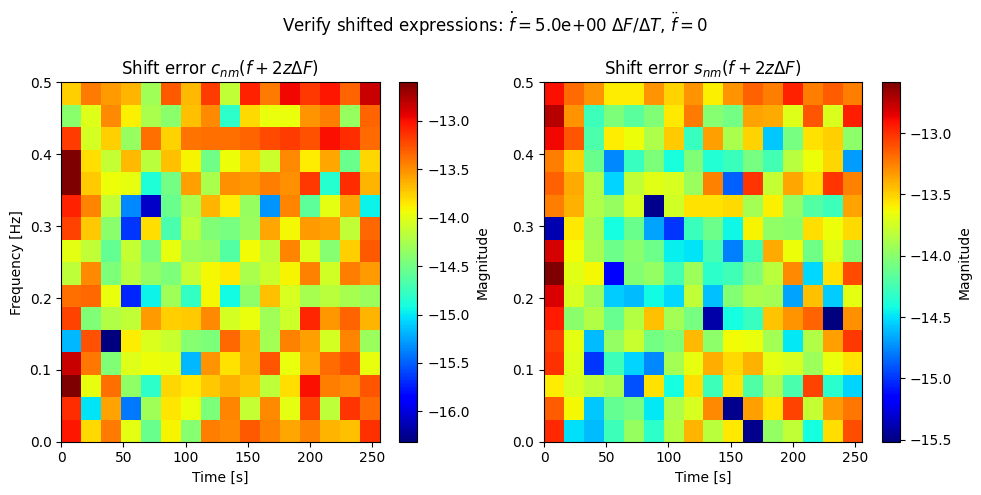

In [177]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

fig.suptitle(r'Verify shifted expressions: $\dot{f}=$'+f'{fdot*wdm.dT/wdm.dF:.1e}'+r' $\Delta F/\Delta T$, $\ddot{f}=0$')

im = axes[0].imshow(jnp.log10(jnp.abs(CNM_z[:,:wdm.Nf]-cnm_z[:,:wdm.Nf])).T, 
           aspect='auto', origin='lower', 
           extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
fig.colorbar(im, label='Magnitude', ax=axes[0])
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Frequency [Hz]')
axes[0].set_title(r'Shift error $c_{nm}(f+2z\Delta F)$')

im = axes[1].imshow(jnp.log10(jnp.abs(SNM_z[:,:wdm.Nf]-snm_z[:,:wdm.Nf])).T, 
           aspect='auto', origin='lower', 
           extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
fig.colorbar(im, label='Magnitude', ax=axes[1])
axes[1].set_xlabel('Time [s]')
axes[1].set_title(r'Shift error $s_{nm}(f+2z\Delta F)$')

plt.tight_layout()
plt.show()

In [210]:
transformer = TFW.waveforms.Transformer(wdm, 
                 num_freq_points=1000,
                 fdot_grid_spec=(0.0, 0.001, 2))



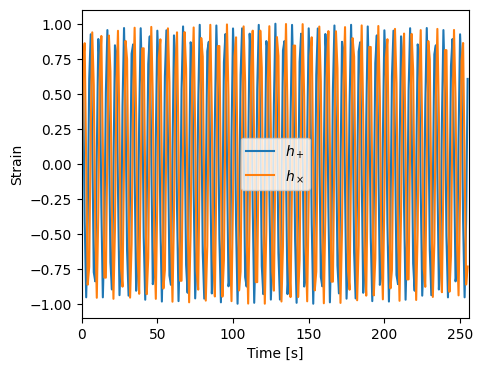

In [220]:
def amplitude(t):
    return jnp.exp(-0.5*((t-wdm.T/2)/(400))**2)

def phase_angle(t):
    f, fdot = 0.18, 0.000
    return 2*np.pi*f*(t-wdm.T/2) + np.pi*fdot*(t-wdm.T/2)**2

def frequency(t):
    f, fdot = 0.18, 0.000
    return f + 0.5*fdot*(t-wdm.T/2)

def frequency_derivative(t):
    return 0.000 * np.ones_like(t)

hp = amplitude(wdm.times) * np.cos(phase_angle(wdm.times))
hc = amplitude(wdm.times) * np.sin(phase_angle(wdm.times))

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(wdm.times, hp, label=r'$h_+$')
ax.plot(wdm.times, hc, label=r'$h_\times$')
ax.set_xlim(0, wdm.T)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Strain')
ax.legend()
plt.show()

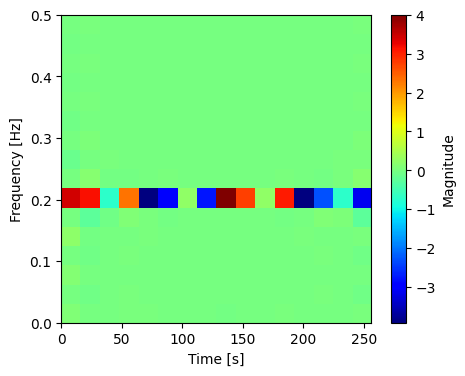

In [221]:
wnm_plus = wdm(hp)
wnm_cross = wdm(hc)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(wnm_plus.T,
           aspect='auto', origin='lower', 
           extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
fig.colorbar(im, label='Magnitude', ax=ax)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [Hz]')
plt.show()

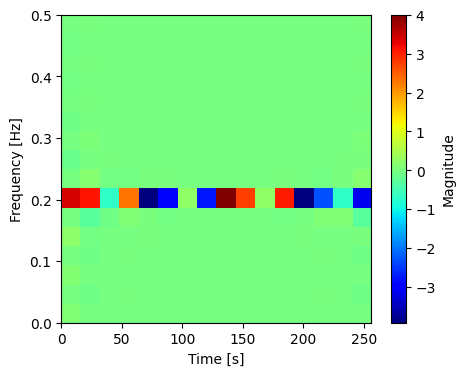

In [222]:
tn = wdm.dT * jnp.arange(wdm.Nt)

amp, phase, freq, fdot = amplitude(tn), phase_angle(tn), frequency(tn), frequency_derivative(tn)

WNM = transformer.transform(amp, phase, freq, fdot)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(WNM.real.T,
           aspect='auto', origin='lower', 
           extent=[0., wdm.T, 0., wdm.f_Ny], cmap='jet')
fig.colorbar(im, label='Magnitude', ax=ax)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [Hz]')
plt.show()

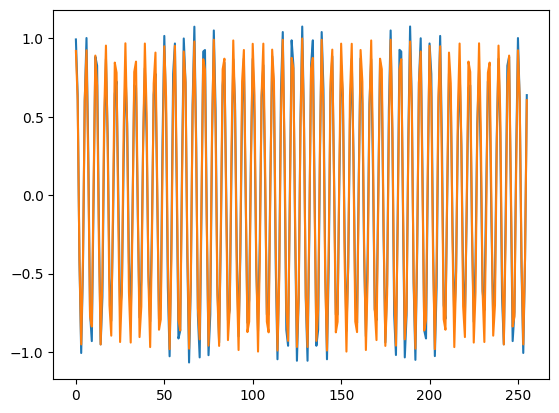

In [224]:
plt.plot(wdm.times, wdm.idwt(WNM.real))
plt.plot(wdm.times, hp, label=r'$h_+$')
plt.show()

In [215]:
wnm = wnm_plus + (1j)*wnm_cross

def inner_product(A, B):
    return jnp.sum(jnp.real(A[:,1:]*jnp.conj(B[:,1:])))

inner_product(wnm, WNM)/jnp.sqrt(inner_product(wnm, wnm) * inner_product(WNM, WNM))

Array(0.99999423, dtype=float64)